In [300]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [352]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.lines import Line2D  # legend marker

def read_brain_graphml(
    graph_id,
    edge_topk=200,
    base_dir="oasis3_graphmls_scale2",
    use_cluster_features=True,
):
    """
    Load, visualize, and return a connectome .graphml file,
    with nodes sorted numerically, and node_features built from (hemisphere, region).
    Adds legend showing cluster labels.
    """

    # ---------------------------------------------------------
    # 1. Load the graph
    # ---------------------------------------------------------
    path = f"{base_dir}/sub-{graph_id}_atlas-L2018_res-scale2_conndata-network_connectivity.graphml"
    G = nx.read_graphml(path)

    original_nodes = list(G.nodes())
    n = len(original_nodes)

    # ---------------------------------------------------------
    # 2. Extract node-level attributes
    # ---------------------------------------------------------
    pos = np.zeros((n, 3))
    hemis, regions = [], []

    for i, node in enumerate(original_nodes):
        d = G.nodes[node]
        pos[i] = [
            float(d["dn_position_x"]),
            float(d["dn_position_y"]),
            float(d["dn_position_z"]),
        ]
        hemis.append(d.get("dn_hemisphere", "unknown"))
        regions.append(d.get("dn_region", "unknown"))

    # ---------------------------------------------------------
    # 3. Sort nodes numerically (if possible)
    # ---------------------------------------------------------
    try:
        node_ids = np.array([int(x) for x in original_nodes])
        sort_idx = np.argsort(node_ids)
        nodes = [str(x) for x in node_ids[sort_idx]]
        print("[INFO] Nodes sorted numerically.")
    except ValueError:
        sort_idx = np.argsort(np.array(original_nodes, dtype=str))
        nodes = np.array(original_nodes)[sort_idx].tolist()
        print("[INFO] Nodes sorted lexicographically (non-numeric names).")

    pos = pos[sort_idx]
    hemis = [hemis[i] for i in sort_idx]
    regions = [regions[i] for i in sort_idx]
    node_to_idx = {name: i for i, name in enumerate(nodes)}

    # ---------------------------------------------------------
    # 4. Extract and remap edges
    # ---------------------------------------------------------
    edges, weights = [], []
    for u, v, ed in G.edges(data=True):
        i, j = node_to_idx[u], node_to_idx[v]
        if i == j:
            continue  # self-loop skip
        edges.append((i, j))
        weights.append(float(ed.get("number_of_fibers", 1.0)))

    edges = np.array(edges, dtype=int)
    weights = np.array(weights, dtype=float)
    print(f"[INFO] Loaded {n} nodes and {len(edges)} edges (sorted).")

    # ---------------------------------------------------------
    # 5. Build cluster-like node_features from (hemisphere, region)
    # ---------------------------------------------------------
    hemi_vals = ["left", "right", "central"]
    region_vals = ["cortical", "subcortical"]

    combo_to_idx = {}
    combos = []
    for h in hemi_vals:
        for r in region_vals:
            combo_to_idx[(h, r)] = len(combos)
            combos.append((h, r))
    K = len(combos)  # 6

    if use_cluster_features:
        node_features = np.zeros((n, K), dtype=float)
        for i, (h, r) in enumerate(zip(hemis, regions)):
            key = (h, r)
            if key in combo_to_idx:
                node_features[i, combo_to_idx[key]] = 1.0
    else:
        node_features = pos.copy()

    # ---------------------------------------------------------
    # 6. Visualization (color by cluster + legend)
    # ---------------------------------------------------------
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection="3d")

    cluster_colors = [
        "#1f77b4",  # left cortical
        "#ff7f0e",  # left subcortical
        "#2ca02c",  # right cortical
        "#d62728",  # right subcortical
        "#9467bd",  # central cortical
        "#8c564b",  # central subcortical
    ]

    node_color_list = []
    cluster_ids = []
    for h, r in zip(hemis, regions):
        key = (h, r)
        if key in combo_to_idx:
            cid = combo_to_idx[key]
            node_color_list.append(cluster_colors[cid])
            cluster_ids.append(cid)
        else:
            node_color_list.append("gray")
            cluster_ids.append(None)

    ax.scatter(
        pos[:, 0], pos[:, 1], pos[:, 2],
        s=30, c=node_color_list, alpha=0.9, depthshade=False
    )

    # draw top-k weighted edges
    k = min(edge_topk, len(edges))
    idx = np.argsort(-weights)[:k]
    segs = [[pos[e[0]], pos[e[1]]] for e in edges[idx]]
    lc = Line3DCollection(segs, linewidths=0.5, alpha=0.25, colors="k")
    ax.add_collection3d(lc)

    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.view_init(elev=80, azim=-90)
    ax.set_title("Structural connectome (colored by hemi×region cluster)")
    plt.tight_layout()

    # Legend
    legend_elements = [
        Line2D([0], [0], marker="o", color="w", label=f"{h}-{r}",
               markerfacecolor=cluster_colors[combo_to_idx[(h, r)]], markersize=8)
        for (h, r) in combos
    ]
    ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.05, 1.0))

    plt.show()

    # ---------------------------------------------------------
    # 7. Return dictionary
    # ---------------------------------------------------------
    return {
        "graph": G,
        "nodes": nodes,
        "pos": pos,
        "hemisphere": hemis,
        "region": regions,
        "edges": edges,
        "edge_weights": weights,
        "node_features": node_features,
    }



import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def visualize_diff_brain_graph(
    G1_data,
    G2_data,
    topk=None,
    use_cluster=True,
):
    """
    두 개의 brain graph 데이터(dict)를 받아서
    - 공통 edge는 안 그리고
    - G1에만 있는 edge: 파란색
    - G2에만 있는 edge: 빨간색
    을 그리되,
    edge weight가 큰 것부터 topk개만 보여주고,
    weight에 따라 투명도를 다르게 그린다.

    Parameters
    ----------
    G1_data, G2_data : dict
        read_brain_graphml(...)이 반환한 딕셔너리
    topk : int or None
        diff edge가 너무 많을 때 weight 큰 순으로 topk만 그림
    use_cluster : bool
        hemisphere×region 6개 조합으로 노드 색칠 + legend
    """
    pos = G1_data["pos"]

    # 1) 무방향 edge로 맞춰서 set 만들기
    edges1 = [tuple(sorted(e)) for e in G1_data["edges"]]
    edges2 = [tuple(sorted(e)) for e in G2_data["edges"]]

    set1 = set(edges1)
    set2 = set(edges2)

    only1 = list(set1 - set2)   # G1 only
    only2 = list(set2 - set1)   # G2 only

    # edge → weight dict 만들어두기 (무방향 기준)
    w1 = {}
    for (i, j), w in zip(edges1, G1_data["edge_weights"]):
        key = (i, j) if i <= j else (j, i)
        w1[key] = w

    w2 = {}
    for (i, j), w in zip(edges2, G2_data["edge_weights"]):
        key = (i, j) if i <= j else (j, i)
        w2[key] = w

    # weight 기준으로 정렬해서 topk 자르기
    only1_sorted = sorted(only1, key=lambda e: w1.get(e, 0.0), reverse=True)
    only2_sorted = sorted(only2, key=lambda e: w2.get(e, 0.0), reverse=True)

    if topk is not None:
        only1_sorted = only1_sorted[:topk]
        only2_sorted = only2_sorted[:topk]

    print(f"[INFO] G1-only edges: {len(only1_sorted)}, G2-only edges: {len(only2_sorted)}")

    fig = plt.figure(figsize=(10, 10))   # 🔹 그림 크기 키움
    ax = fig.add_subplot(111, projection="3d")
    
    # --- edge alpha 스케일 계산용 ---
    ws1 = np.array([w1.get(e, 0.0) for e in only1_sorted]) if only1_sorted else np.array([])
    ws2 = np.array([w2.get(e, 0.0) for e in only2_sorted]) if only2_sorted else np.array([])
    all_ws = np.concatenate([ws1, ws2]) if ws1.size + ws2.size > 0 else np.array([1.0])
    wmax = all_ws.max() if all_ws.size > 0 else 1.0
    
    # --- G1 only (blue) ---
    if len(only1_sorted) > 0:
        for (i, j), w in zip(only1_sorted, ws1):
            alpha = 0.1 + 0.5 * (w / (wmax + 1e-12))  # 🔹 더 투명하게
            ax.plot(
                [pos[i, 0], pos[j, 0]],
                [pos[i, 1], pos[j, 1]],
                [pos[i, 2], pos[j, 2]],
                color="blue",
                linewidth=1.0,
                alpha=alpha,
            )
    
    # --- G2 only (red) ---
    if len(only2_sorted) > 0:
        for (i, j), w in zip(only2_sorted, ws2):
            alpha = 0.1 + 0.5 * (w / (wmax + 1e-12))  # 🔹 동일한 투명도 스케일
            ax.plot(
                [pos[i, 0], pos[j, 0]],
                [pos[i, 1], pos[j, 1]],
                [pos[i, 2], pos[j, 2]],
                color="red",
                linewidth=1.0,
                alpha=alpha,
            )

    # --- 노드 색칠 ---
    if use_cluster:
        hemis = G1_data.get("hemisphere", ["unknown"] * len(pos))
        regions = G1_data.get("region", ["unknown"] * len(pos))

        # 6개 조합 고정
        combos = [
            ("left", "cortical"),
            ("left", "subcortical"),
            ("right", "cortical"),
            ("right", "subcortical"),
            ("central", "cortical"),
            ("central", "subcortical"),
        ]
        combo_to_idx = {c: i for i, c in enumerate(combos)}
        cluster_colors = [
            "#1f77b4",  # left cortical
            "#ff7f0e",  # left subcortical
            "#2ca02c",  # right cortical
            "#d62728",  # right subcortical
            "#9467bd",  # central cortical
            "#8c564b",  # central subcortical
        ]

        node_colors = []
        for h, r in zip(hemis, regions):
            key = (h, r)
            if key in combo_to_idx:
                node_colors.append(cluster_colors[combo_to_idx[key]])
            else:
                node_colors.append("gray")
    else:
        node_colors = "k"

    ax.scatter(
        pos[:, 0], pos[:, 1], pos[:, 2],
        s=20, c=node_colors, alpha=1.0, depthshade=False
    )

    # --- 시각화 정리 ---
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.view_init(elev=80, azim=-90)
    ax.set_facecolor("white")
    fig.patch.set_facecolor("white")
    ax.set_title("Diff only: blue = G₁ only, red = G₂ only")

    # --- legend (clusters + diff 설명) ---
    legend_elements = []
    if use_cluster:
        for (h, r), color in zip(combos, cluster_colors):
            legend_elements.append(
                Line2D([0], [0], marker="o", color="w",
                       label=f"{h}-{r}", markerfacecolor=color, markersize=6)
            )
    # diff 설명도 추가
    legend_elements.extend([
        Line2D([0], [0], color="blue", lw=2, label="G₁ only edges"),
        Line2D([0], [0], color="red", lw=2, label="G₂ only edges"),
    ])

    ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.05, 1.0))

    plt.tight_layout()
    plt.show()

import os
import re

def parse_oasis3_filenames(folder_path):
    """
    OASIS3 GraphML 파일명에서 user_id와 scan_id를 추출.

    예시 파일명:
    sub-OAS30001_ses-d0757_atlas-L2018_res-scale2_conndata-network_connectivity.graphml

    Returns:
        records: list of dicts [{ 'filename': ..., 'user_id': ..., 'scan_id': ... }, ...]
    """
    records = []
    pattern = re.compile(r"sub-(OAS\d+)_ses-(d\d+)", re.IGNORECASE)

    for fname in os.listdir(folder_path):
        if not fname.endswith(".graphml"):
            continue
        match = pattern.search(fname)
        if match:
            user_id, scan_id = match.groups()
            records.append({
                "filename": fname,
                "user_id": user_id,
                "scan_id": scan_id
            })
    return records

def adjacency_from_edges(data, symmetric=True, normalize=True):
    """
    source_data / target_data 딕셔너리에서 adjacency matrix 생성.
    self-loop(i==j)는 무조건 무시.
    """
    n = len(data["nodes"])
    A = np.zeros((n, n), dtype=float)

    edges = np.asarray(data["edges"], dtype=int)
    weights = np.asarray(data["edge_weights"], dtype=float)

    for (i, j), w in zip(edges, weights):
        # 1) self-loop는 건너뛴다
        if i == j:
            continue

        # 2) 정방향
        A[i, j] = w

        # 3) 무방향이면 대칭으로
        if symmetric:
            A[j, i] = w

    if normalize:
        m = np.max(np.abs(A))
        if m > 0:
            A = A/m

    return A

def visualize_adjacency_diff_heatmap(source_data, target_data, normalize=True, cmap="bwr"):
    """
    두 뇌 그래프 간 adjacency 차이를 heatmap으로 시각화
    (빨강: target > source, 파랑: target < source)
    """
    # 1. adjacency 생성
    A_src = adjacency_from_edges(source_data)
    A_tgt = adjacency_from_edges(target_data)

    # 2. 차이 계산
    diff = A_tgt - A_src

    # 3. 정규화 (선택적)
    if normalize:
        m = np.max(np.abs(diff))
        if m > 0:
            diff = diff / m

    # 4. 히트맵 시각화
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(diff, cmap=cmap, vmin=-1, vmax=1)

    ax.set_title("Adjacency difference heatmap (target - source)", fontsize=12)
    ax.set_xlabel("Target node index")
    ax.set_ylabel("Source node index")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Δ weight (normalized)")

    plt.tight_layout()
    plt.show()

# 사용 예시
folder = "oasis3_graphmls_scale2"  # 실제 폴더 경로로 변경
records = parse_oasis3_filenames(folder)

[INFO] Nodes sorted numerically.
[INFO] Loaded 170 nodes and 5498 edges (sorted).


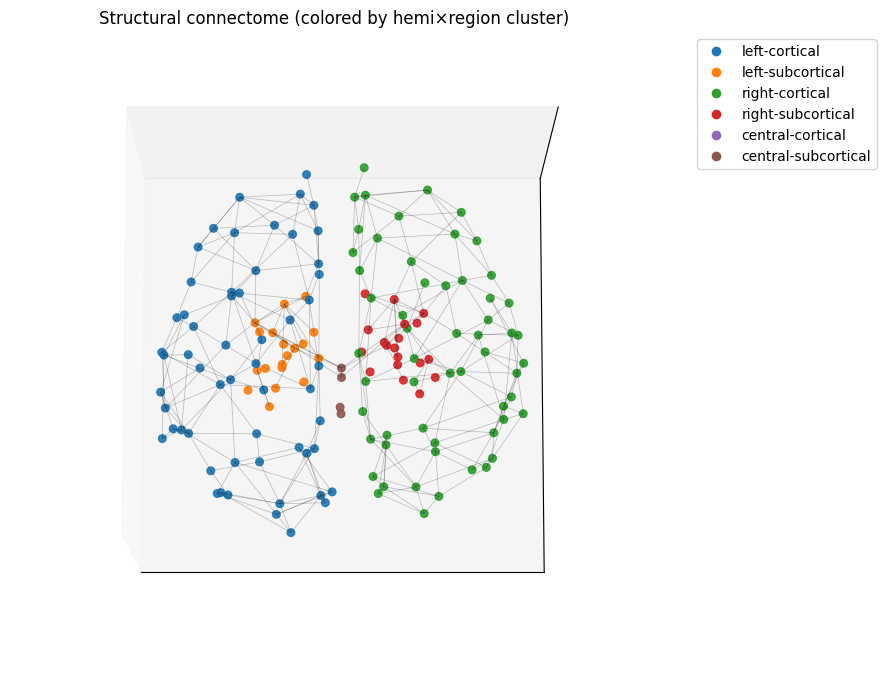

[INFO] Nodes sorted numerically.
[INFO] Loaded 170 nodes and 5279 edges (sorted).


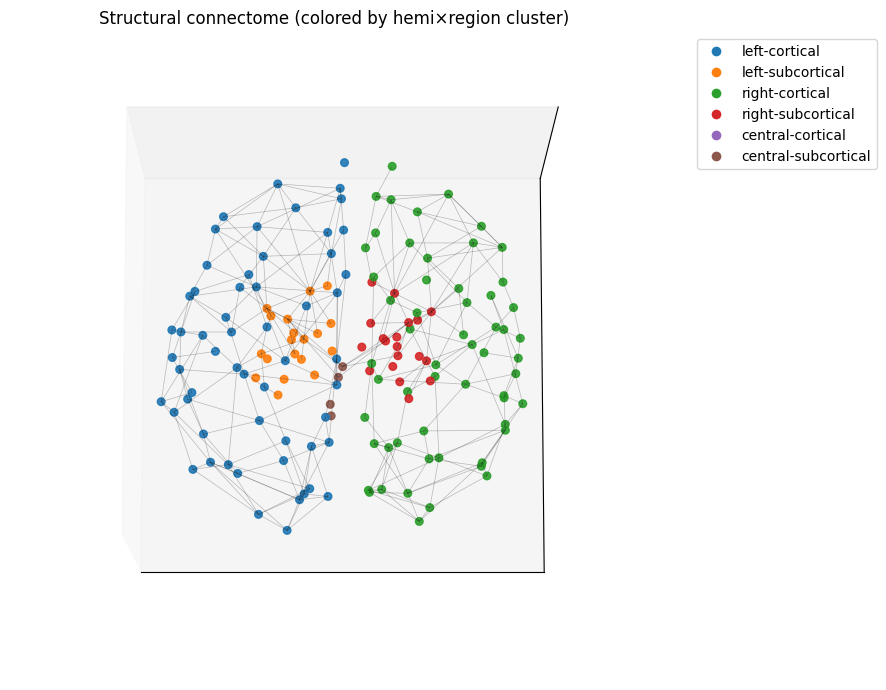

In [329]:
source_data = read_brain_graphml(
    graph_id=f'{records[2]["user_id"]}_ses-{records[2]["scan_id"]}',
    edge_topk=300,
    use_cluster_features=True
)

target_data = read_brain_graphml(
    graph_id=f'{records[0]["user_id"]}_ses-{records[0]["scan_id"]}',
    edge_topk=300,
    use_cluster_features=True
)


In [330]:
import numpy as np

def clean_brain_dict(data, bad_nodes):
    """
    data: read_brain_graphml(...) 이 반환한 dict
    bad_nodes: 제거할 노드 인덱스 (리스트나 np.array, 예: [71,72,...])

    반환: 같은 형식의 dict이지만 bad node와 그와 연결된 edge가 모두 제거되고
         노드 인덱스가 0..(n_clean-1)로 다시 매겨진 버전
    """
    bad_nodes = set(int(i) for i in bad_nodes)
    n = len(data["nodes"])

    # 1) good node mask
    keep_mask = np.ones(n, dtype=bool)
    for i in bad_nodes:
        keep_mask[i] = False

    # 2) old index -> new index 매핑
    old_to_new = {}
    new_nodes = []
    for old_idx, keep in enumerate(keep_mask):
        if keep:
            new_idx = len(new_nodes)
            old_to_new[old_idx] = new_idx
            new_nodes.append(data["nodes"][old_idx])

    # 3) 노드 관련 것들 필터링
    new_pos = data["pos"][keep_mask]
    new_hemi = [h for i, h in enumerate(data["hemisphere"]) if keep_mask[i]]
    new_region = [r for i, r in enumerate(data["region"]) if keep_mask[i]]
    new_node_features = data["node_features"][keep_mask]

    # 4) edge 필터링: bad node가 하나라도 들어가면 버린다
    old_edges = data["edges"]
    old_weights = data["edge_weights"]

    new_edges = []
    new_weights = []
    for (i, j), w in zip(old_edges, old_weights):
        if (i in bad_nodes) or (j in bad_nodes):
            continue  # 이 edge는 버림
        # remap
        ni = old_to_new[i]
        nj = old_to_new[j]
        new_edges.append((ni, nj))
        new_weights.append(w)

    new_edges = np.array(new_edges, dtype=int)
    new_weights = np.array(new_weights, dtype=float)

    cleaned = {
        "graph": data["graph"],     # 원하면 이것도 subgraph로 만들 수 있는데 일단 원본 보존
        "nodes": new_nodes,
        "pos": new_pos,
        "hemisphere": new_hemi,
        "region": new_region,
        "edges": new_edges,
        "edge_weights": new_weights,
        "node_features": new_node_features,
    }

    return cleaned

bad_idx = np.array([71, 72, 73, 74, 75, 76, 79, 154, 155, 156, 157, 158, 159, 162])

source_data = clean_brain_dict(source_data, bad_idx)
target_data = clean_brain_dict(target_data, bad_idx)

# 이제 둘 다 노드 개수가 줄어들었으니까
n = len(source_data["nodes"])
assert n == len(target_data["nodes"])

In [331]:
A_X = adjacency_from_edges(source_data)
A_Y = adjacency_from_edges(target_data)

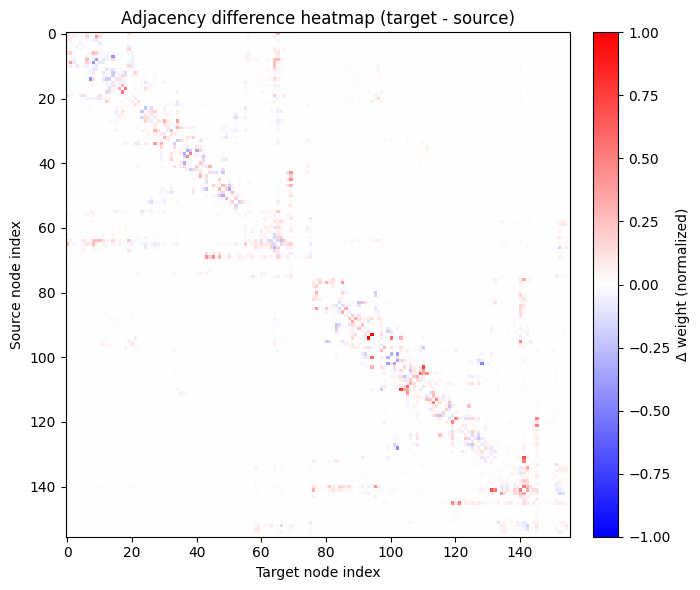

In [332]:
visualize_adjacency_diff_heatmap(source_data,target_data)


Total runtime: 0.591 seconds


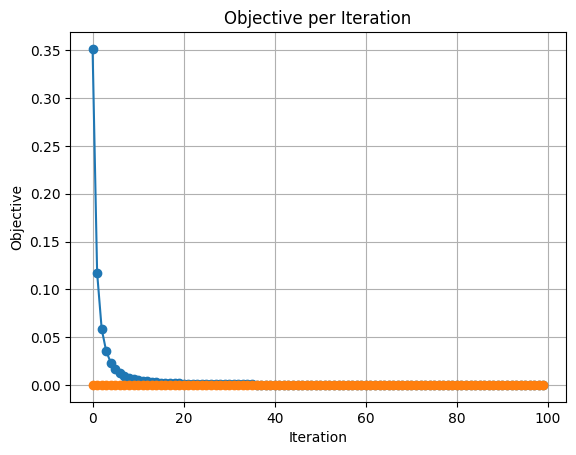

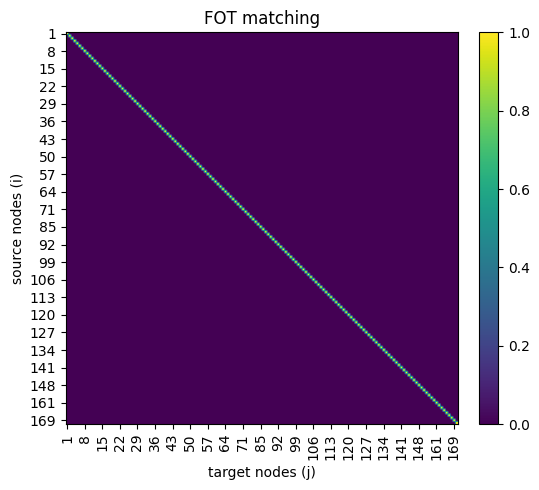

In [333]:
import sys
sys.path.append('../code')
import FOT
sys.path.append('../simulation')
from data_generation import *
from scipy.spatial.distance import cdist

n = len(source_data['nodes'])
a = b = np.ones((n,)) / n

def random_coupling_with_marginals(p, q, max_iter=1000, tol=1e-9, seed=None):
    rng = np.random.default_rng(seed)
    K = rng.random((len(p), len(q)))
    u = np.ones_like(p)
    v = np.ones_like(q)
    for _ in range(max_iter):
        u_prev = u.copy()
        u = p / (K @ v)
        v = q / (K.T @ u)
        if np.linalg.norm(u - u_prev, 1) < tol:
            break
    P = np.diag(u) @ K @ np.diag(v)
    P /= P.sum()  # optional normalization
    return P

# pi = random_coupling_with_marginals(a,b)
pi = np.outer(a,b)

import time

C_f = cdist(source_data['node_features'], target_data['node_features'], metric="sqeuclidean")

DX = all_pairs_geodesic(A_X,weighted=True)
DY = all_pairs_geodesic(A_Y,weighted=True)

for D in (DX, DY):
    mask = np.isinf(D)
    if mask.any():
        finite_max = D[~mask].max()
        D[mask] = finite_max

t_heat = 1
DX_diff, DX_rkhs = diffusion_and_rkhs_distances(A_X,t=t_heat,method='expm')
DY_diff, DY_rkhs = diffusion_and_rkhs_distances(A_Y,t=t_heat,method='expm')

alpha = 0.5
T = 100

start_time = time.time()  # 시작 시간 기록

model = FOT.ConvexFusedTransport(
    alpha=alpha,
    fw_max_iter=T,
    fw_stepsize='classic',
    tol=1e-40,
    lmo_method='emd',
    pre_Cf=C_f,
    pre_DX=DX_rkhs,
    pre_DY=DY_rkhs,
    normalize=True,
    verbose=0
).fit(
    X=np.array(range(n)).reshape(-1, 1),
    Y=np.array(range(n)).reshape(-1, 1),
    FX=None, FY=None, init=pi,
    return_hard_assignment=True
)

end_time = time.time()  # 종료 시간 기록
elapsed = end_time - start_time

print(f"\nTotal runtime: {elapsed:.3f} seconds")

plt.plot(range(len(model.obj_history_)), model.obj_history_, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective per Iteration')
plt.grid(True)
plt.show()

import numpy as np
import matplotlib.pyplot as plt

def visualize_matching(P, src_nodes=None, tgt_nodes=None, title="Transport / matching matrix"):
    """
    P : (n, n) transport or permutation matrix, e.g. model.P_
    src_nodes, tgt_nodes : list of node names (optional, for axis ticks)
    """
    P = np.asarray(P, dtype=float)
    n, m = P.shape
    assert n == m, "지금은 n==m 케이스만 시각화하도록 해놨어"

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(P, cmap="viridis")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(title)
    ax.set_xlabel("target nodes (j)")
    ax.set_ylabel("source nodes (i)")

    # 노드 이름 있으면 축에 살짝만 찍어주기
    if src_nodes is not None and len(src_nodes) == n:
        step = max(1, n // 20)  # 너무 많으면 다 찍지 말고 적당히
        ax.set_yticks(np.arange(0, n, step))
        ax.set_yticklabels([src_nodes[i] for i in range(0, n, step)])
    if tgt_nodes is not None and len(tgt_nodes) == m:
        step = max(1, m // 20)
        ax.set_xticks(np.arange(0, m, step))
        ax.set_xticklabels([tgt_nodes[j] for j in range(0, m, step)], rotation=90)

    plt.tight_layout()
    plt.show()

P = model.P_   # or model.pi_
visualize_matching(
    P,
    src_nodes=source_data["nodes"],
    tgt_nodes=target_data["nodes"],
    title="FOT matching"
)

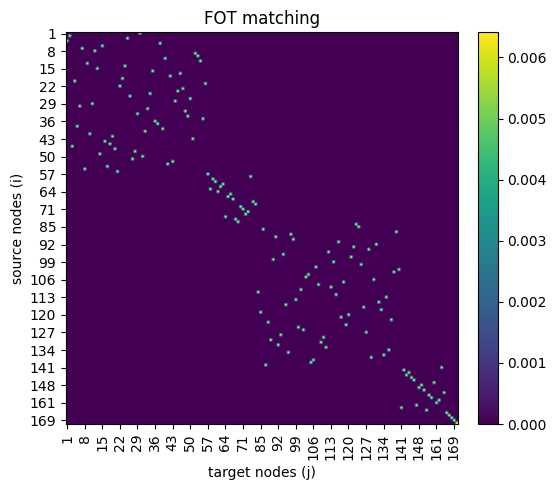

In [334]:
import ot

T_FGW = ot.gromov.fused_gromov_wasserstein(
    C_f, DX_rkhs, DY_rkhs, G_0=pi,max_iter=T,
    alpha=alpha, loss_fun='square_loss'
)

visualize_matching(
    T_FGW,
    src_nodes=source_data["nodes"],
    tgt_nodes=target_data["nodes"],
    title="FOT matching"
)

[INFO] Nodes sorted numerically.
[INFO] Loaded 170 nodes and 5098 edges (sorted).


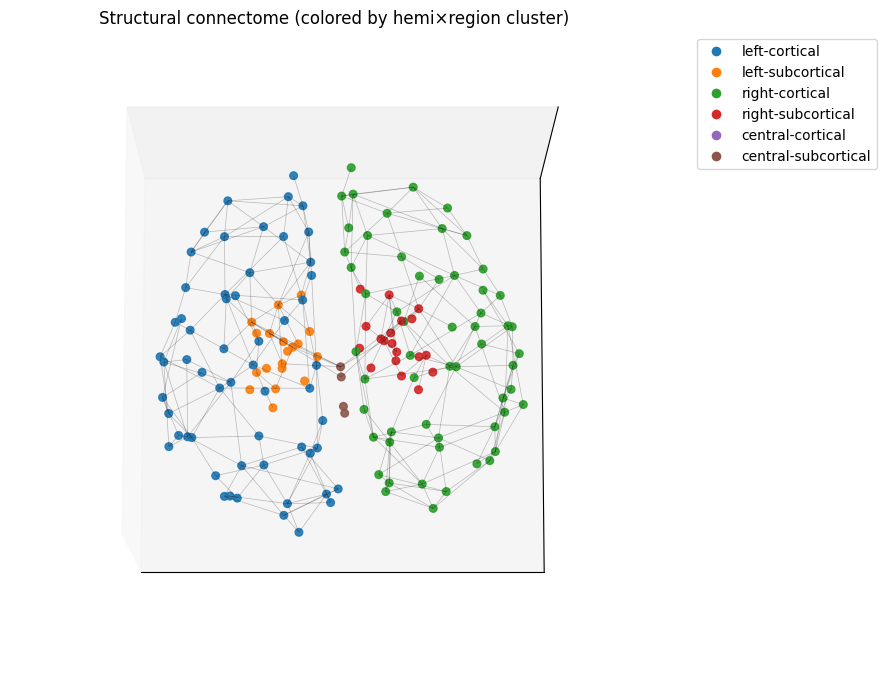

In [335]:
source_data2 = read_brain_graphml(
    graph_id=f'{records[3]["user_id"]}_ses-{records[3]["scan_id"]}',
    edge_topk=300,
    use_cluster_features=True
)

In [336]:
src2_feat = source_data2['node_features']

print("src NaN:", np.isnan(src2_feat).any(), "inf:", np.isinf(src2_feat).any())
print("src NaN idx:", np.where(np.isnan(src2_feat).any(axis=1))[0])

src NaN: False inf: False
src NaN idx: []


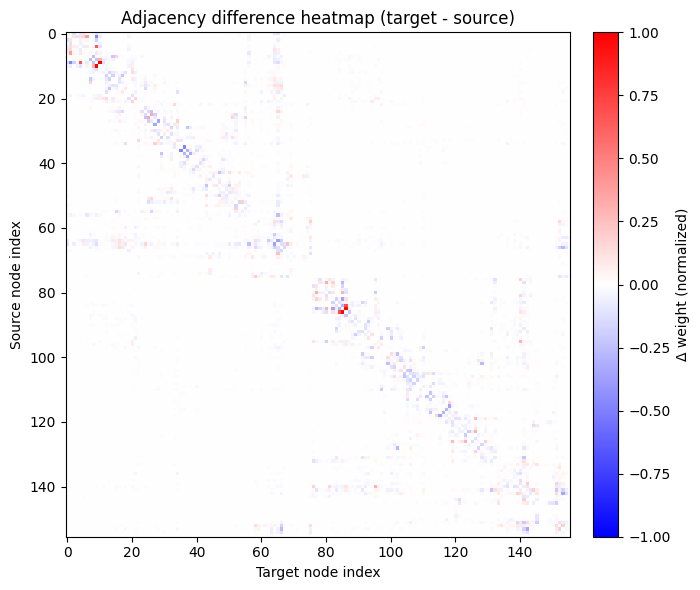

In [337]:
source_data2 = clean_brain_dict(source_data2, bad_idx)

visualize_adjacency_diff_heatmap(source_data,source_data2)

[INFO] G1-only edges: 10, G2-only edges: 10


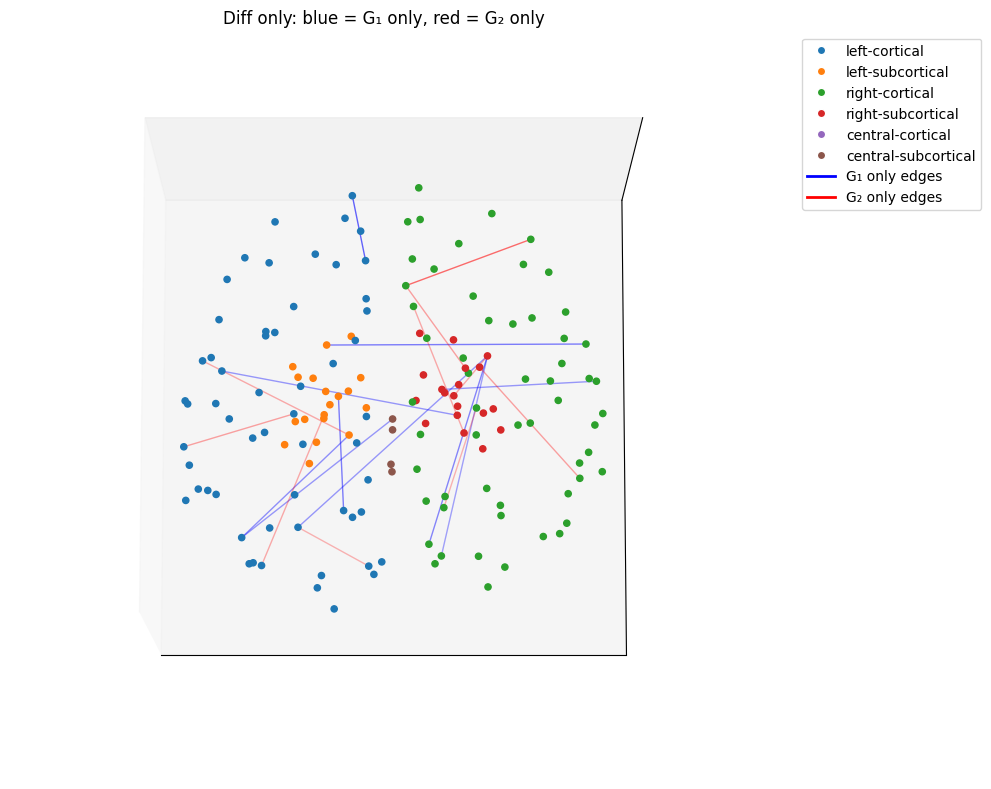

In [353]:
visualize_diff_brain_graph(source_data,source_data2,topk=10)

In [346]:
import numpy as np

def transfer_edge_change_with_P(
    P,
    src_old_data,
    src_new_data,
    tgt_old_data,
    make_adj_func,
    symmetric=True,
):
    """
    source/target brain dict들과 매칭 P가 주어졌을 때
    'edge weight 변화'를 source → target으로 옮기는 함수.

    Parameters
    ----------
    P : (n, n) ndarray
        source(i) -> target(j) transport / permutation
    src_old_data : dict
        과거 시점 source (10년 전)
    src_new_data : dict
        현재/미래 시점 source (10년 후)
    tgt_old_data : dict
        과거 시점 target (source_old와 같은 시점)
    make_adj_func : callable
        data(dict) -> adjacency (n, n) 를 만들어주는 함수
        예: adjacency_from_edges
    symmetric : bool
        adjacency를 대칭으로 볼지 여부

    Returns
    -------
    tgt_pred_data : dict
        tgt_old_data를 복사해서 adjacency만 업데이트한 버전
        (edges/edge_weights는 다시 뽑아야 할 수 있음)
    A_tgt_pred : (n, n) ndarray
        예측된 target adjacency
    """

    # 0. adjacency 만들기
    A_s_old = make_adj_func(src_old_data, symmetric=symmetric)  # (n,n)
    A_s_new = make_adj_func(src_new_data, symmetric=symmetric)  # (n,n)
    A_t_old = make_adj_func(tgt_old_data, symmetric=symmetric)  # (n,n)

    n = A_s_old.shape[0]
    assert A_s_old.shape == (n, n)
    assert A_s_new.shape == (n, n)
    assert A_t_old.shape == (n, n)
    assert P.shape == (n, n)

    # 1. source의 엣지 변화량
    delta_s = A_s_new - A_s_old    # (n, n)

    # 2. 매칭으로 target index로 옮기기
    #    Δ_t = P^T Δ_s P
    delta_t = P.T @ delta_s @ P    # (n, n)

    # 3. target 옛날 adjacency에 더하기
    A_t_pred = A_t_old + delta_t

    # 음수나 이상한 값 생기면 클리핑
    A_t_pred = np.where(A_t_pred < 0, 0.0, A_t_pred)

    # 4. dict로도 돌려주고 싶으면: (edge list로 다시 변환)
    #    여기서는 최소한 복사만 해준다
    tgt_pred_data = dict(tgt_old_data)
    tgt_pred_data["adjacency_pred"] = A_t_pred

    return tgt_pred_data, A_t_pred

def adjacency_to_brain_dict_like(base_data, A, tol=1e-12, symmetric=True):
    """
    adjacency 행렬 A를 우리가 쓰던 brain dict 포맷으로 변환한다.
    base_data의 노드/좌표/hemisphere/region은 그대로 쓰고
    edge/edge_weights만 A에서 다시 뽑는다.
    """
    n = A.shape[0]
    edges = []
    weights = []
    for i in range(n):
        # symmetric이면 절반만
        j_start = i + 1 if symmetric else 0
        for j in range(j_start, n):
            w = A[i, j]
            if abs(w) > tol:
                edges.append((i, j))
                weights.append(float(w))

    edges = np.array(edges, dtype=int)
    weights = np.array(weights, dtype=float)

    data_pred = dict(base_data)  # 얕은 복사
    data_pred["edges"] = edges
    data_pred["edge_weights"] = weights
    return data_pred


[INFO] G1-only edges: 10, G2-only edges: 10


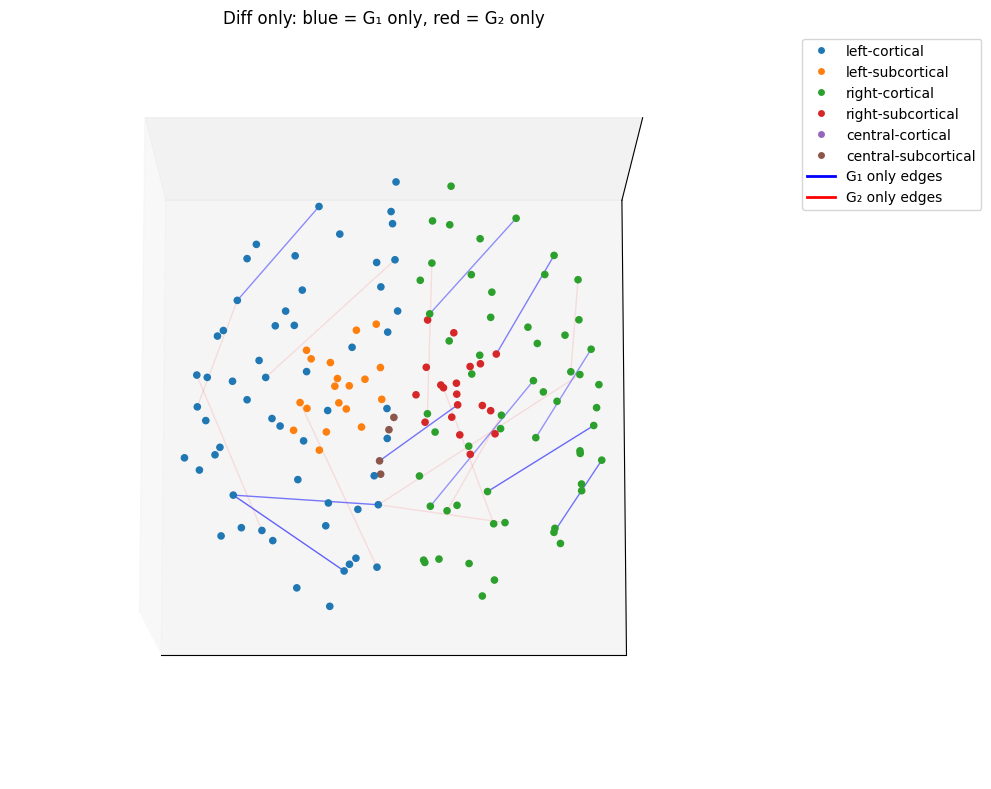

In [354]:
# 1) edge 변화 transfer (네가 이미 한 부분)
target_data2, A_target2 = transfer_edge_change_with_P(
    P=model.P_,
    src_old_data=source_data,
    src_new_data=source_data2,
    tgt_old_data=target_data,
    make_adj_func=adjacency_from_edges,
    symmetric=True,
)

# 2) 행렬에서 다시 edge list로 뽑아서 dict로 맞추기
target_data_pred = adjacency_to_brain_dict_like(
    base_data=target_data,   # 좌표/label은 원래거 그대로
    A=A_target2,
    tol=1e-8,
    symmetric=True,
)

# 3) 원래 target과 예측 target의 차이를 3D로 보기
visualize_diff_brain_graph(
    target_data,
    target_data_pred,
    topk=10,          # 원하는 만큼
    use_cluster=True,  # 6색 legend
)

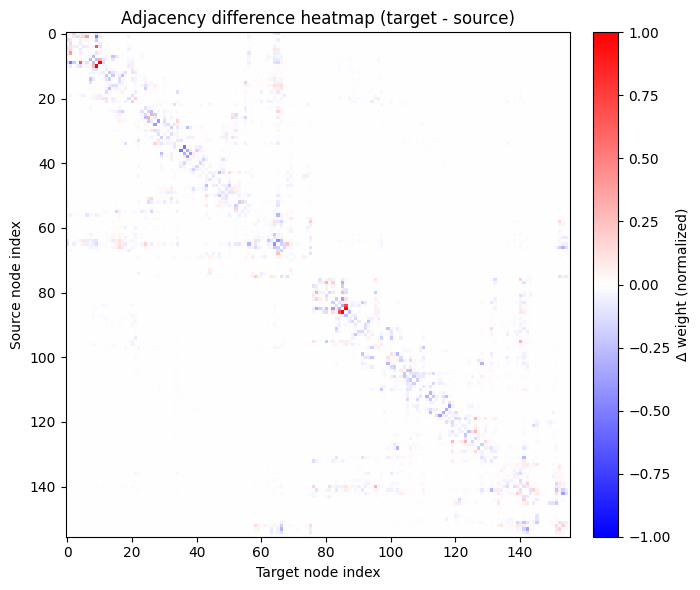

In [350]:
visualize_adjacency_diff_heatmap(target_data,target_data_pred)

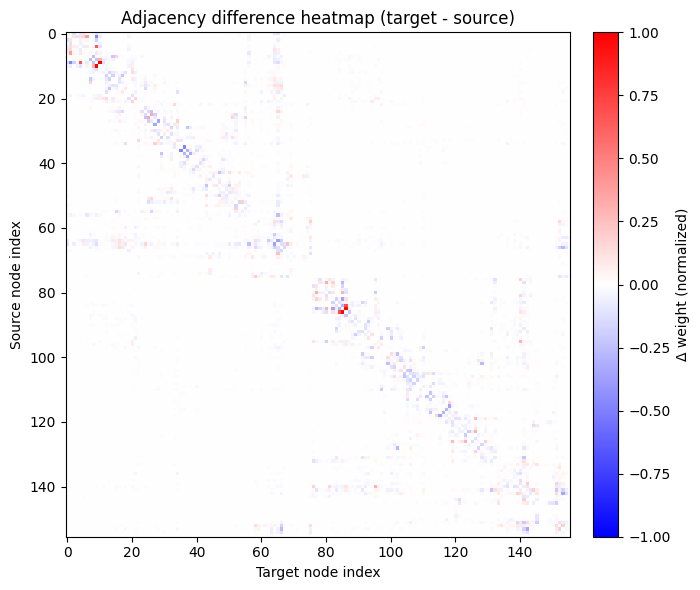

In [351]:
visualize_adjacency_diff_heatmap(source_data,source_data2)

In [356]:
A_s_old = adjacency_from_edges(source_data, symmetric=True)
A_s_new = adjacency_from_edges(source_data2, symmetric=True)
A_t_old = adjacency_from_edges(target_data, symmetric=True)
A_t_pred = adjacency_from_edges(target_data_pred, symmetric=True)

# source diff
D_s = A_s_new - A_s_old

# target diff를 source 순서로 되돌리기
# D_t = A_t_pred - A_t_old  = P.T @ D_s @ P
D_t = A_t_pred - A_t_old
D_t_in_source_order = P @ D_t @ P.T   # ← 이걸 heatmap으로 그리면 모양이 source diff랑 같아야 한다

visualize_adjacency_diff_heatmap(D_s)
visualize_adjacency_diff_heatmap(D_t_in_source_order)

TypeError: visualize_adjacency_diff_heatmap() missing 1 required positional argument: 'target_data'